# Tree Ensembles and Random Forests - Lab

## Introduction

In this lab, we'll create some popular tree ensemble models such as a bag of trees and random forest to predict a person's salary based on information about them. 

## Objectives

In this lab you will: 

- Train a random forest model using `scikit-learn`  
- Access, visualize, and interpret feature importances from an ensemble model 

## Import data

In this lab, you'll use personal attributes to predict whether people make more than 50k/year.  The dataset was extracted from the census bureau database. The goal is to use this dataset to try and draw conclusions regarding what drives salaries. More specifically, the target variable is categorical (> 50k and <= 50 k). Let's create a classification tree!

To get started, run the cell below to import everything we'll need for this lab. 

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

Our dataset is stored in the file `'salaries_final.csv'`.  

In the cell below, import the dataset from this file and store it in a DataFrame. Be sure to set the `index_col` parameter to `0`.  Then, display the `.head()` of the DataFrame to ensure that everything loaded correctly.

In [2]:
# Import the data
salaries = pd.read_csv('./salaries_final.csv')
salaries.tail()
print(salaries.shape)

(32561, 8)


In total, there are 6 predictors, and one outcome variable, the salary, `Target` - `<= 50k` and `>50k`.

The 6 predictors are:

- `Age`: continuous 

- `Education`: Categorical. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool 

- `Occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces 

- `Relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried 

- `Race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black 

- `Sex`: Female, Male 

First, we'll need to store our `'Target'` column in a separate variable and drop it from the dataset.  

Do this in the cell below. 

In [3]:
# Split the outcome and predictor variables
target = salaries['Target']
features = salaries.drop('Target', axis = 1)

In the cell below, examine the data type of each column:  

In [4]:
# Your code here
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 8 columns):
Unnamed: 0      32561 non-null int64
Age             32561 non-null int64
Education       32561 non-null object
Occupation      32561 non-null object
Relationship    32561 non-null object
Race            32561 non-null object
Sex             32561 non-null object
Target          32561 non-null object
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


Great. `'Age'` is numeric, as it should be. Now we're ready to create some dummy columns and deal with our categorical variables.  

In the cell below, use Pandas to create dummy columns for each of categorical variables. If you're unsure of how to do this, check out the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).  

In [5]:
# Create dummy variables
data = pd.get_dummies(salaries, drop_first=True)
data.head()

,Unnamed: 0,Age,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,...,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male,Target_>50K
0,0,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,1,50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,2,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,3,53,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,4,28,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [6]:
data = data.drop('Target_>50K', axis=1)

Now, split `data` and `target` into 75/25 training and test sets. Set the `random_state` to 123.  

In [7]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.25, random_state=123)
print(data_train.shape, target_train.shape)
print(data_test.shape, target_test.shape)

(24420, 41) (24420,)
(8141, 41) (8141,)


## Build a "regular" tree as a baseline

We'll begin by fitting a regular decision tree classifier, so that we have something to compare our ensemble methods to.  

### Build the tree

In the cell below, instantiate and fit a decision tree classifier. Set the `criterion` to `'gini'`, and a `max_depth` of `5`.  Then, fit the tree to the training data and labels.   

In [8]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_model = tree_clf.fit(data_train, target_train)
tree_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Feature importance

Let's quickly examine how important each feature ended up being in our decision tree model. Check the `feature_importances_` attribute of the trained model to see what it displays. 

In [9]:
# Feature importance
tree_clf.feature_importances_
print(list(zip(data_train.columns, tree_clf.feature_importances_)))

[('Unnamed: 0', 0.0024618917621813253), ('Age', 0.3036149320778865), ('Education_11th', 0.0), ('Education_12th', 0.0), ('Education_1st-4th', 0.0), ('Education_5th-6th', 0.0), ('Education_7th-8th', 0.0), ('Education_9th', 0.0), ('Education_Assoc-acdm', 0.0), ('Education_Assoc-voc', 0.0), ('Education_Bachelors', 0.010924175188418195), ('Education_Doctorate', 0.00731029603765776), ('Education_HS-grad', 0.01769376896674665), ('Education_Masters', 0.013617313799937303), ('Education_Preschool', 0.0), ('Education_Prof-school', 0.0), ('Education_Some-college', 0.0), ('Occupation_Adm-clerical', 0.0), ('Occupation_Armed-Forces', 0.0), ('Occupation_Craft-repair', 0.0), ('Occupation_Exec-managerial', 0.10859855561427952), ('Occupation_Farming-fishing', 0.0), ('Occupation_Handlers-cleaners', 0.0), ('Occupation_Machine-op-inspct', 0.0), ('Occupation_Other-service', 0.01126312866884133), ('Occupation_Priv-house-serv', 0.0), ('Occupation_Prof-specialty', 0.13013323996813903), ('Occupation_Protective-s

That matrix isn't very helpful, but a visualization of the data it contains could be.  Run the cell below to plot a visualization of the feature importances for this model. 

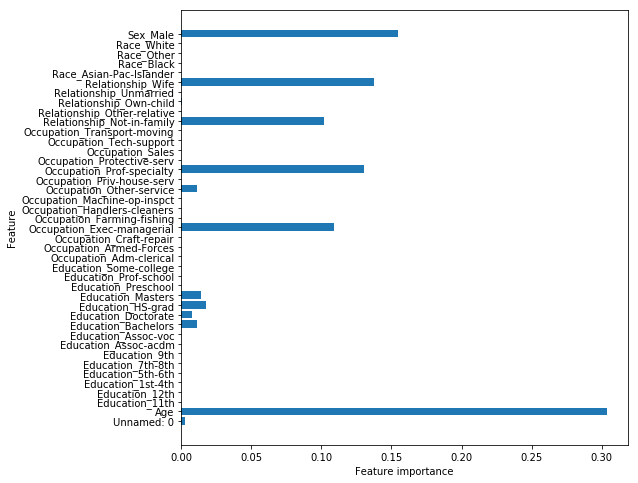

In [10]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

### Model performance

Next, let's see how well our model performed on the test data. 

In the cell below:

* Use the model to generate predictions on the test set  
* Print out a `confusion_matrix` of the test set predictions 
* Print out a `classification_report` of the test set predictions 

In [11]:
# Test set predictions
pred = tree_model.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(target_test, pred))
print(classification_report(target_test, pred))

[[5825  340]
 [1201  775]]
              precision    recall  f1-score   support

       <=50K       0.83      0.94      0.88      6165
        >50K       0.70      0.39      0.50      1976

   micro avg       0.81      0.81      0.81      8141
   macro avg       0.76      0.67      0.69      8141
weighted avg       0.80      0.81      0.79      8141



Now, let's check the model's accuracy. Run the cell below to display the test set accuracy of the model. 

In [12]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(target_test, pred) * 100))

Testing Accuracy for Decision Tree Classifier: 81.07%


## Bagged trees

The first ensemble approach we'll try is a bag of trees. This will make use of **_Bagging_**, along with a number of decision tree classifier models.  

Now, let's instantiate a [`BaggingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).  First, initialize a `DecisionTreeClassifier` and set the same parameters that we did above for `criterion` and `max_depth`.  Also set the `n_estimators` parameter for our `BaggingClassifier` to `20`. 

In [13]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)
bagged_tree

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Great! Now, fit it to our training data. 

In [14]:
# Fit to the training data
model = bagged_tree.fit(data_train, target_train)
model

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Checking the accuracy of a model is such a common task that all (supervised learning) models have a `.score()` method that wraps the `accuracy_score()` helper function we've been using. All we have to do is pass it a dataset and the corresponding labels and it will return the accuracy score for those data/labels.  

Let's use it to get the training accuracy of our model. In the cell below, call the `.score()` method on our bagging model and pass in our training data and training labels as parameters. 

In [15]:
# Training accuracy score
model.score(data_train, target_train)


0.8172399672399673

Now, let's check the accuracy score that really matters -- our testing accuracy.  This time, pass in our testing data and labels to see how the model did.  

In [16]:
# Test accuracy score
model.score(data_test, target_test)

0.8127994103918438

## Random forests

Another popular ensemble method is the **_Random Forest_**. Let's fit a random forest classifier next and see how it measures up compared to all the others. 

### Fit a random forests model

In the cell below, instantiate and fit a `RandomForestClassifier`, and set the number estimators to `100` and the max depth to `5`. Then, fit the model to our training data. 

In [17]:
# Instantiate and fit a RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, max_depth= 5)
model_fit = forest_clf.fit(data_train, target_train)
model_fit

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now, let's check the training and testing accuracy of the model using its `.score()` method: 

In [18]:
# Training accuracy score
model_fit.score(data_train, target_train)

0.7982800982800983

In [19]:
# Test accuracy score
model_fit.score(data_test, target_test)

0.7968308561601769

### Feature importance

In [20]:
# Feature importance
forest_clf.feature_importances_
print(list(zip(data_train.columns, forest_clf.feature_importances_)))

[('Unnamed: 0', 0.0035388381322562137), ('Age', 0.25642654711256496), ('Education_11th', 0.0038739899230937997), ('Education_12th', 9.270194101414339e-05), ('Education_1st-4th', 1.3221815906880154e-05), ('Education_5th-6th', 0.00018082999290624816), ('Education_7th-8th', 0.0019336455007177569), ('Education_9th', 0.0006841637359673225), ('Education_Assoc-acdm', 0.00029870418031180927), ('Education_Assoc-voc', 0.000320820501349393), ('Education_Bachelors', 0.04803859578321154), ('Education_Doctorate', 0.020003585490153415), ('Education_HS-grad', 0.02479782207625171), ('Education_Masters', 0.04140480756511718), ('Education_Preschool', 7.71802586499689e-06), ('Education_Prof-school', 0.02103366568626303), ('Education_Some-college', 0.0023258057102864536), ('Occupation_Adm-clerical', 0.0010456602694672032), ('Occupation_Armed-Forces', 5.47405446570158e-07), ('Occupation_Craft-repair', 0.0012228526149290772), ('Occupation_Exec-managerial', 0.08243881267586917), ('Occupation_Farming-fishing',

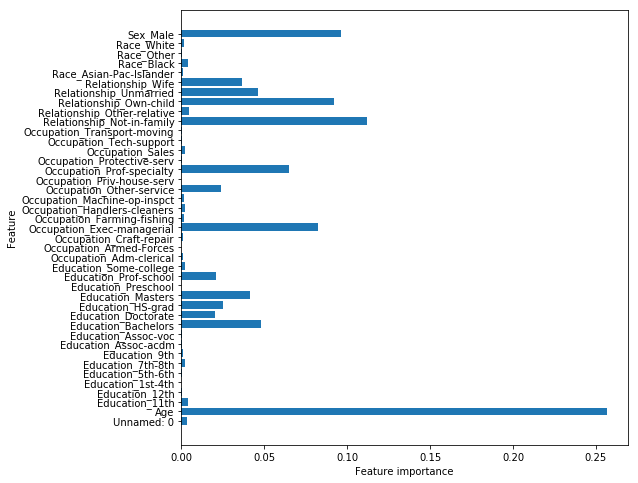

In [21]:
plot_feature_importances(forest_clf)

Note: "relationship" represents what this individual is relative to others. For example an
individual could be a Husband. Each entry only has one relationship, so it is a bit of a weird attribute.

Also note that more features show up. This is a pretty typical result. 

### Look at the trees in your forest

Let's create a forest with some small trees. You'll learn how to access trees in your forest!

In the cell below, create another `RandomForestClassifier`.  Set the number of estimators to 5, the `max_features` to 10, and the `max_depth` to 2.

In [31]:
# Instantiate and fit a RandomForestClassifier
forest_2_clf = RandomForestClassifier(max_features=10, n_estimators=5, max_depth=2)
model_fit = forest_2_clf.fit(data_train, target_train)


Making `max_features` smaller will lead to very different trees in your forest! The trees in your forest are stored in the `.estimators_` attribute.

In the cell below, get the first tree from `forest_2.estimators_` and store it in `rf_tree_1`

In [32]:
# First tree from forest_clf
rf_tree_1 = forest_clf.estimators_[0]
rf_tree_1

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1340754471, splitter='best')

Now, we can reuse our `plot_feature_importances()` function to visualize which features this tree was given to use duing subspace sampling. 

In the cell below, call `plot_feature_importances()` on `rf_tree_1`.

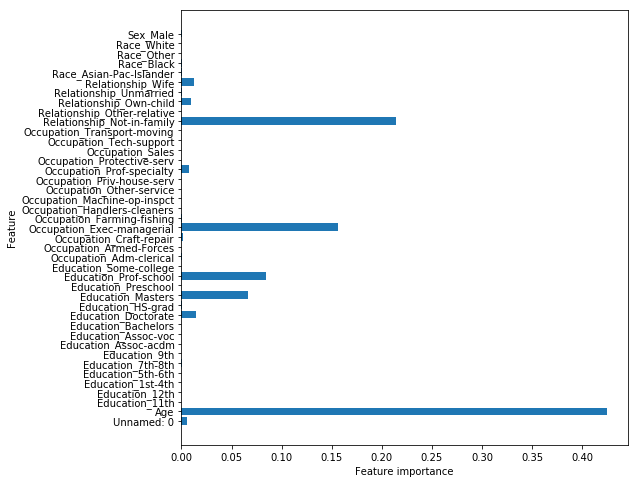

In [33]:
# Feature importance
plot_feature_importances(rf_tree_1)

Now, grab the second tree and store it in `rf_tree_2`, and then pass it to `plot_feature_importances()` in the following cell so we can compare which features were most useful to each. 

In [36]:
# Second tree from forest_2
rf_tree_2 = forest_2_clf.estimators_[1]
rf_tree_2

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=474057613, splitter='best')

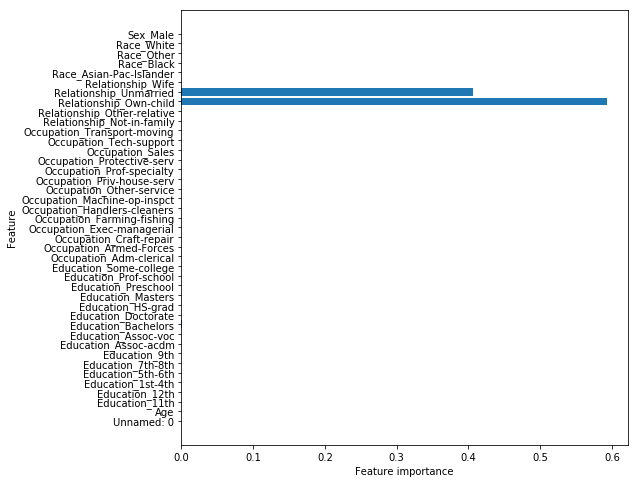

In [37]:
# Feature importance
plot_feature_importances(rf_tree_2)

We can see by comparing the two plots that the two trees we examined from our random forest look at different attributes, and have wildly different feature importances!

## Summary

In this lab, we got some practice creating a few different tree ensemble methods. We also learned how to visualize feature importances, and compared individual trees from a random forest to see if we could notice the differences in the features they were trained on. 